# Assignment 3: Association Analysis

To read Excel files, you might need to install the `xlrd` package, using something like:

    conda activate myEnvironment # where myEnvironment is the conda environment you use for this module
    conda install xlrd


You may find the following useful to obtain the data from the UCI data repository, and to read it into a dataframe.

In [191]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

df = pd.read_excel("Online Retail.xlsx")

In [192]:
dfCopy = df

In [193]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [194]:
dfCopy.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [196]:
import numpy as np
np.sum(dfCopy.isnull())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

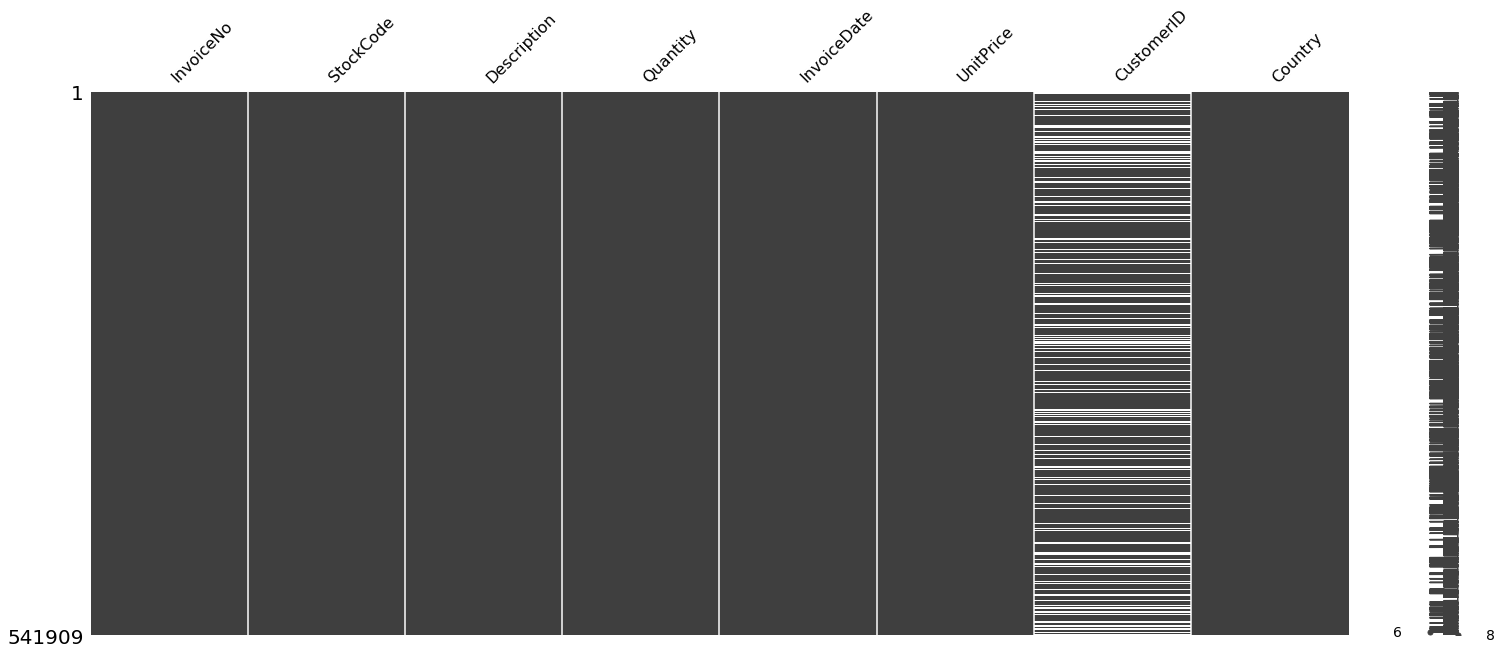

In [197]:
import missingno as msno
%matplotlib inline
msno.matrix(dfCopy);


In [198]:
print("Percentage of customers missing: ", round(dfCopy['CustomerID'].isnull().sum() * 100 / len(dfCopy),2),"%" )

Percentage of customers missing:  24.93 %


a. We are missing values in the CustomerID and Description columns. 
b. Since 25% of the customer ID's are missing, we will create and fill a new column that has a 1 when customer ID is null and a 0 when it is not. 
c. We will investigate the records where the CustomerID field is null to determine whether to erase those rows or fill in the missing values. 
d. Since we won't be doing analysis on the descriptions of the orders, we can leave the null values as is

In [199]:
null_df = dfCopy[dfCopy.isnull().any(axis=1)] # remove missing values
null_df.shape

(135080, 8)

### Exploratory data analysis

In [200]:
dfCopy = df.sort_values('Quantity', ascending=False)
dfCopy.head(11)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom
74614,542504,37413,NaN,5568,2011-01-28 12:03:00,0.00,NaN,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom
220843,556231,85123A,?,4000,2011-06-09 15:04:00,0.00,NaN,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2011-07-19 17:04:00,0.06,14609.0,United Kingdom
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom


The top 10 most popular items are sold in/to the UK. Apparently paper craft little birdie is very popular, along with medium ceramic top storage jar. I will remove the items with 'NaN' descriptor. These entries associated with nan CustomerID entries and 131 lower case descriptions which describe problems with the orders and no details of the item ordered. In addition, the data for United Kingdom contains negative values associated with negative UnitPrice values. Removing the rows containing NaN values therefore cleans several issues that complicate this analysis in the absence of the data owner.

In [201]:
dfCopy = dfCopy.dropna() #remove NaN

In [202]:
dfCopy.shape # 541909 - 406829 = dropped 135,080 entries

(406829, 8)

In [203]:
# in addition I will check for duplicate entries and remove those
dfCopy.drop_duplicates(inplace = True)

In [204]:
dfCopy.shape

(401604, 8)

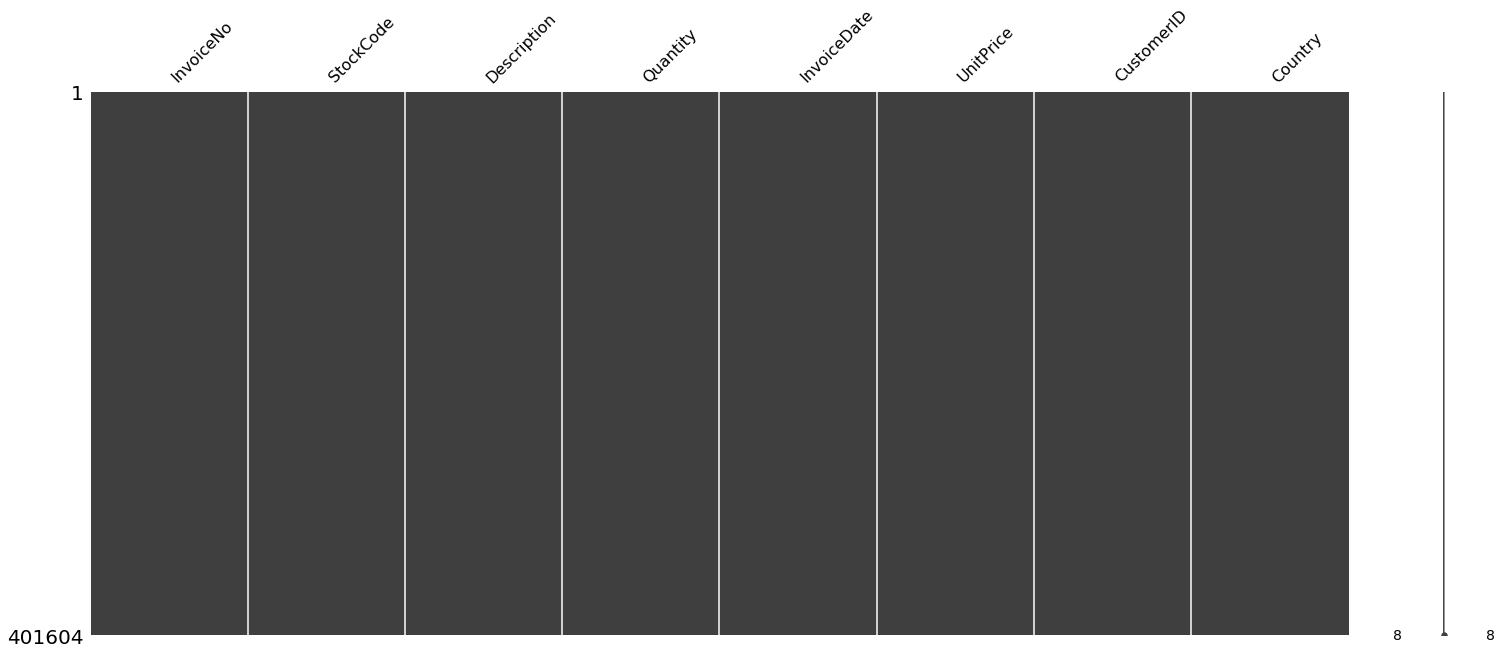

In [205]:
msno.matrix(dfCopy);

We now have no missing values and have removed assumed erroneous results and duplicates.

In [206]:
# by_country = dfCopy.groupby('Country')
# by_country.describe()

In [207]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

grouped  = dfCopy.groupby(['Country']).count()['Quantity'].sort_values(ascending=False) #verify if we have to do count or sum of quantity

data_plot = [go.Bar(x=grouped.index, y=grouped.values)]
layout = go.Layout(yaxis={'type':'log', 'autorange':True, 'title':'Log10 number of orders'},xaxis={'title':'country'})#I'm using a log scale just for visualisation as the UK dominates the market
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

As we can see that in the `Quantity` column, the count for Germany is 9480 which is closest to the number of records required(9042) by hovering over the data.

In [208]:
dfCopy1=dfCopy;

In [209]:
df1=df

In [210]:
# retail_de = dfCopy1[dfCopy1['Country']=='Germany']

In [211]:
# dfCopy1.groupby('Country').count().reset_index().sort_values(
#   'InvoiceNo', ascending = False).head()

In [212]:
basket_de = (dfCopy1[dfCopy1['Country']=="Germany"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket_de.head(10)

# dfCopy1=dfCopy1.groupby([dfCopy1['Country']=="Germany"])['Quantity'].sum()

Description,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [213]:
def sum_to_boolean(x):
  if x<=0:
    return 0
  else:
    return 1
basket_de_final = basket_de.applymap(sum_to_boolean)
basket_de_final.head(10)

Description,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
frequent_itemsets_de = apriori(basket_de_final, min_support = 0.06,
  use_colnames = True)
frequent_itemsets_de.sort_values('support', ascending = False).head()

,support,itemsets
7,0.620232,(POSTAGE)
11,0.185738,(ROUND SNACK BOXES SET OF4 WOODLAND )
22,0.170813,"(POSTAGE, ROUND SNACK BOXES SET OF4 WOODLAND )"
10,0.119403,(ROUND SNACK BOXES SET OF 4 FRUITS )
21,0.114428,"(ROUND SNACK BOXES SET OF 4 FRUITS , POSTAGE)"


In [215]:
a_rules = association_rules(frequent_itemsets_de, metric = "lift",
  min_threshold = 1)
a_rules.sort_values('lift',ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
27,(ROUND SNACK BOXES SET OF 4 FRUITS ),"(POSTAGE, ROUND SNACK BOXES SET OF4 WOODLAND )",0.119403,0.170813,0.094527,0.791667,4.634709,0.074132,3.980100
26,"(POSTAGE, ROUND SNACK BOXES SET OF4 WOODLAND )",(ROUND SNACK BOXES SET OF 4 FRUITS ),0.170813,0.119403,0.094527,0.553398,4.634709,0.074132,1.971772
23,(ROUND SNACK BOXES SET OF4 WOODLAND ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.185738,0.119403,0.099502,0.535714,4.486607,0.077325,1.896670
22,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.119403,0.185738,0.099502,0.833333,4.486607,0.077325,4.885572
29,(ROUND SNACK BOXES SET OF4 WOODLAND ),"(ROUND SNACK BOXES SET OF 4 FRUITS , POSTAGE)",0.185738,0.114428,0.094527,0.508929,4.447593,0.073274,1.803347
24,"(ROUND SNACK BOXES SET OF 4 FRUITS , POSTAGE)",(ROUND SNACK BOXES SET OF4 WOODLAND ),0.114428,0.185738,0.094527,0.826087,4.447593,0.073274,4.682007
14,(ROUND SNACK BOXES SET OF 4 FRUITS ),(POSTAGE),0.119403,0.620232,0.114428,0.958333,1.545120,0.040370,9.114428
15,(POSTAGE),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.620232,0.119403,0.114428,0.184492,1.545120,0.040370,1.079814
25,"(ROUND SNACK BOXES SET OF 4 FRUITS , ROUND SNA...",(POSTAGE),0.099502,0.620232,0.094527,0.950000,1.531684,0.032813,7.595357
28,(POSTAGE),"(ROUND SNACK BOXES SET OF 4 FRUITS , ROUND SNA...",0.620232,0.099502,0.094527,0.152406,1.531684,0.032813,1.062417


In [187]:
# Creating subsets of df for each unique country
def df_per_country(df):
    import re
    df_dict = {}
    unique_countries, counts = np.unique(df.Country, return_counts=True)
    for country in unique_countries:
        df_dict["df_{}".format(re.sub('[\s+]', '', country))] = dfCopy[df.Country == country].copy()
        # This line is giving me the warning, I will check in further research
        # After watching Data School video about the SettingWithCopyWarning I figured out the problem
        # When doing df[df.Country == country] adding the .copy() points pandas that this is an actual copy of the original df
        df_dict["df_{}".format(re.sub('[\s+]', '', country))].drop('Country', axis=1, inplace=True)
    return df_dict

# Trick to convert dictionary key/values into variables
# This way we don't need to access dfs by df_dict['df_Australia'] for example
df_dict = df_per_country(df)
locals().update(df_dict)

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\ipykernel_l

In [188]:
# Series plot function summarizing df_Countries
def series_plot(df, by1, by2, by3, period='D'):
    import matplotlib.pyplot as plt
    df_ts = df.reset_index().pivot_table(index='InvoiceDate', 
                                values=['InvoiceNo', 'Quantity', 'UnitPrice'], 
                                aggfunc=('count', 'sum'))
    df_ts = df_ts.loc[:, [('InvoiceNo', 'count'), ('Quantity', 'sum'), ('UnitPrice', 'sum')]]
    df_ts.columns = df_ts.columns.droplevel(1)
    plt.figure(figsize=(14, 6))
    
    plt.subplot(2, 2, 1)
    plt.plot(df_ts.resample(period).sum().bfill()[[by1]], color='navy')
    plt.title('{}'.format(by1));
    plt.xticks(rotation=60);
    plt.subplot(2, 2, 2)
    plt.title('{}'.format(by2));
    plt.plot(df_ts.resample(period).sum().bfill()[[by2]], label='Total Sale', color='orange');
    plt.xticks(rotation=60)
    plt.tight_layout()
    
    plt.figure(figsize=(14, 8))
    plt.title('{}'.format(by3));
    plt.plot(df_ts.resample(period).sum().bfill()[[by3]], label='Total Invoices', color='green');
    plt.tight_layout()

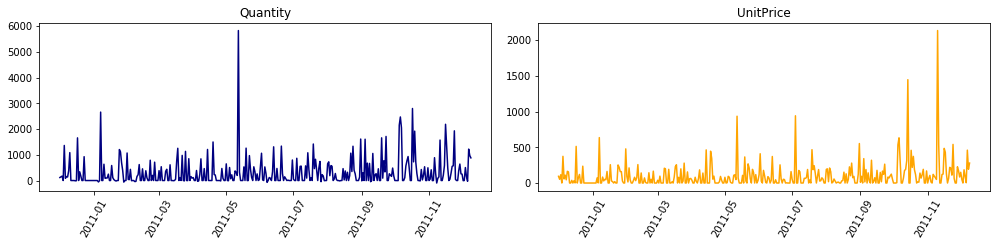

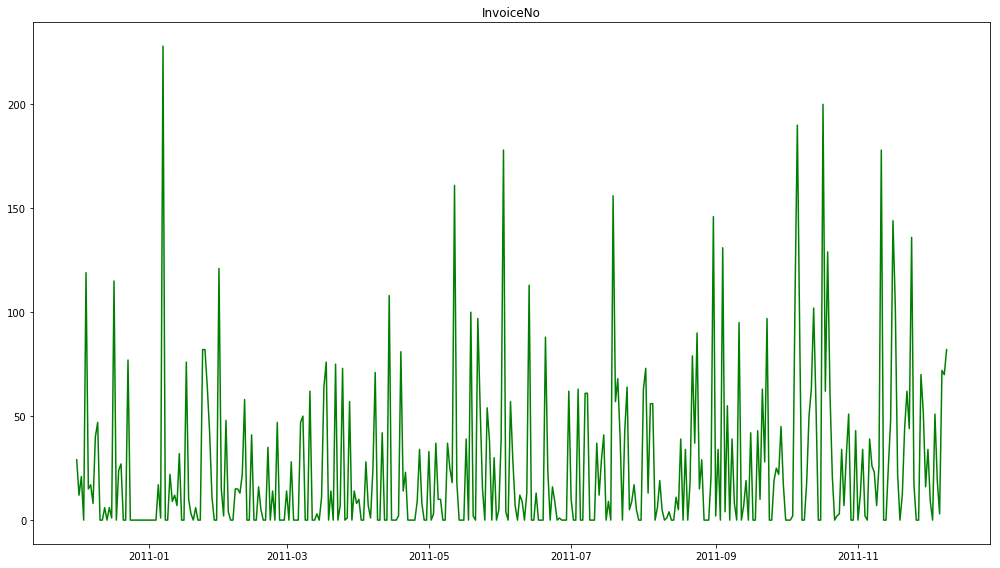

In [189]:
series_plot(df_Germany, 'Quantity', 'UnitPrice', 'InvoiceNo')

In [190]:
# Starting preparation of df for receiving product association
# Cleaning Description field for proper aggregation 
df_Germany.loc[:, 'Description'] = df_Germany.Description.str.strip().copy()
# Once again, this line was generating me the SettingWithCopyWarning, solved by adding the .copy()

# Dummy conding and creation of the baskets_sets, indexed by InvoiceNo with 1 corresponding to every item presented on the basket
# Note that the quantity bought is not considered, only if the item was present or not in the basket
basket = pd.get_dummies(df_Germany.reset_index().loc[:, ('InvoiceNo', 'Description')])
basket_sets = pd.pivot_table(basket, index='InvoiceNo', aggfunc='sum')

KeyError: 'InvoiceNo'

In [159]:
# dfCopy1=dfCopy1.reset_index(drop=True)
# print(dfCopy1)

0    4775510
1     117341
Name: Quantity, dtype: int64


In [161]:
# from mlxtend.frequent_patterns import apriori
# from mlxtend.preprocessing import TransactionEncoder

# te = TransactionEncoder()
# te_ary = te.fit(dfCopy1).transform(dfCopy1)
# dfCopy1 = pd.DataFrame(te_ary, columns=te.columns_)
# dfCopy1
# # apriori(dfCopy1, min_support=0.02)

TypeError: 'int' object is not iterable

In [65]:
# from mlxtend.preprocessing import TransactionEncoder
# te = TransactionEncoder()
# te_ary = te.fit(df1).transform(df1)
# dfCopy = pd.DataFrame(te_ary, columns=te.columns_)
# dfCopy

,C,D,I,N,P,Q,S,U,a,c,...,m,n,o,p,r,s,t,u,v,y
0,False,False,True,True,False,False,False,False,False,True,...,False,True,True,False,False,False,False,False,True,False
1,True,False,False,False,False,False,True,False,False,True,...,False,False,True,False,False,False,True,False,False,False
2,False,True,False,False,False,False,False,False,False,True,...,False,True,True,True,True,True,True,False,False,False
3,False,False,False,False,False,True,False,False,True,False,...,False,True,False,False,False,False,True,True,False,True
4,False,True,True,False,False,False,False,False,True,True,...,False,True,True,False,False,False,True,False,True,False
5,False,False,False,False,True,False,False,True,False,True,...,False,True,False,False,True,False,True,False,False,False
6,True,True,True,False,False,False,False,False,False,False,...,True,False,True,False,True,True,True,True,False,False
7,True,False,False,False,False,False,False,False,False,False,...,False,True,True,False,True,False,True,True,False,True
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [52]:
# # group by customer ID and invoice number to create a basket per customer
# temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
# products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
# products_per_basket[:10].sort_values('Number of products', ascending=False)

,CustomerID,InvoiceNo,Number of products
7,12347.0,573511,47
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
6,12347.0,562032,22
5,12347.0,556201,18
9,12348.0,539318,17
8,12347.0,581180,11
0,12346.0,541431,1
1,12346.0,C541433,1


__Task 1.1__: Select the transactions arising from the `Country` having _9042_ records in the dataframe and convert them to the OneHotEncoded form, where each column has (0,1) values representing the (absence,presence) of that product in a given basket, where each basket (row) is labeled by its `InvoiceNo`.

Hints
1. Use `groupby` and `size()` to determined the number of rows per `Country`
2. Use `groupby` and `sum()` on the `Quantity` to encode as 0 and positive integer, and `reset_index()` so that the rows are labeled by `InvoiceNo`. Remember to set any positive numbers to 1 rather than a frequency count.

__Task 1.2__: Use mlxtend's `apriori` function to find the frequent itemsets where the minimum support threshold is set to 0.02. Hence derive the association rules where the minimum lift threshold is 1.

__Task 1.3__: Defining the _rule length_ to be the total number of products in the rule, plot the distribution of association rules by rule length and explain why the distribution looks like it does. Choosing the _longest_ rules, find the most attractive rule for use when recommending a (set of) products to a customer. Explain why reversing the rule might not be as effective.

_Hints_
1. The rule length is the sum of the lengths of the `antecedents` and `consequents` per rule.
2. Association rules can be used for recommendation to customers who have already bought the antecedent products and might be interested in buying the consequent products. Note that you will need to use (by sorting) and justify suitable association measures to choose the most attractive rule for recommendation purposes.

## Recommender Systems

We use the well-known MovieLens dataset (in this case the small version). You may find the following useful to obtain the data from the GroupLens repository, and to read it into a dataframe.

In [4]:
import os, requests
import numpy as np

#mlSize = "ml-1m"
#mlSize = "ml-100k"
mlSize = "ml-latest-small"
zipUrl = 'http://files.grouplens.org/datasets/movielens/'+mlSize+'.zip'
zipFile = 'data/'+mlSize+'.zip'
dataFile = zipFile
url = zipUrl
dataDir = 'data'
if not os.path.exists(dataDir):
    os.makedirs(dataDir)
if not os.path.isfile(zipFile):
  r = requests.get(zipUrl)
  with open(zipFile, 'wb') as f:
    f.write(r.content)

# Need to unzip the file to read its contents
import zipfile
with zipfile.ZipFile(zipFile,"r") as zip_ref:
  zip_ref.extractall(dataDir)


__Task 2.1__: Read the `users.dat`, `movies.dat` and `ratings.dat` data files into data frames.

_Hints_

1. You may find Pandas `read_csv` provides most of what you need, although you will need to override its default `sep` parameter.

__Task 2.2__: Generate the distribution of ratings (number of user-movie ratings, per rating value).

_Hints_

1. You may find that `value_counts()` helps to count the ratings.

The following code can be used to filter the number of Movies. Choosing a large threshold (like 1750) ensures that only "blockbuster" movies with that number of aggregate ratings will be considered. This is convenient (much reduced runtimes!) when developing your solution, but a less stringent threshold should be used for the result you hand in (100 is suggested). You should also apply similar filters to the Users.

To apply this filter to the ratings dataframe, you might find the `isin(filteredSet)` function useful.

In [ ]:
minMovieRatings = 1750
#minMovieRatings = 100
filterMovies = ratingsDf['MovieID'].value_counts() > minMovieRatings
filterMovies = filterMovies[filterMovies].index
filterMovies = df[df['MovieID'].isin(filterMovies)]
len(filterMovies)

__Task 2.3__: Using the filtered ratings dataframe, count the ratings per User and plot this data in a histogram. You should do the same with the Movies and comment on the similarities and differences between the two distributions.

_Hint_

1. You might find the `groupby()` and `count()` functions suitable for generating the data you need. 

__Task 2.4__: Repeat Task 2.3 above, but deriving the average ratings rather than their counts.

__Task 2.5__: Load the (filtered) movies ratings data from the dataframe we have been exploring into the preferred 3-column format used by the `scikit-suprise` package. Now benchmark the performance (in terms of RMS error, time to fit, and time to generate predictions for test data) of the `SVD()`, `SlopeOne()`, `NMF()`, `KNNBasic()` recommendation algorithms. Discuss the strengths and weaknesses of each algorithm, based on its benchmarked results.

_Hints_

1. `scikit-surprise` provides `Reader` and `Dataset` functions to load one dataframe from another.
2. `scikit-surprise` also provides a `cross_validate` function that can be used to estimate the test error in the test data, using the requested error metric.
3. When collecting the benchmark data, you might find it convenient to loop over the algorithms and to add the results for each algorithm as a row to your benchmark array or dataframe.